In [72]:
from sklearn.model_selection import train_test_split
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import to_pil_image



In [2]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)

seed_everything(42)

In [3]:
os.chdir('C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\Images')
data = pd.read_csv('data.csv')
data.head()

,images,labels
0,20130529_01_Driv_001_f .jpg,0
1,20130529_01_Driv_002_f .jpg,0
2,20130529_01_Driv_003_f .jpg,0
3,20130529_01_Driv_004_f .jpg,0
4,20130529_01_Driv_005_f .jpg,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data['images'], data['labels'], 
                                                    test_size = 0.2, stratify= data['labels'],
                                                    random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(484,)
(484,)
(122,)
(122,)


In [5]:
def preproc_images(image_paths, label_images, target_size = (80,80)):
    images = []
    labels = []
    idx = 0
    for img_path in image_paths:
        with Image.open(img_path) as img:
            img_resized = img.resize(target_size)
            #img_gray = img_resized.convert('L')
            img_array = np.array(img_resized) / 255.0
            images.append(img_array)
            labels.append(label_images[idx])
        idx += 1
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

os.chdir('C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\Images\\DrivImages')
train_images, train_labels = preproc_images(list(X_train), list(y_train),  target_size = (224,224))
test_images, test_labels = preproc_images(list(X_test), list(y_test),  target_size = (224,224))

Instead of using standard methods of augmentation to augment our images, lets try training a GAN to produce reconstructions of our image from a latent space. However, since GANs only reconstruct the image, we need to add a classifier on of the generator to assign a label to the generated images

In [6]:
labels_to_augment = [1, 2]
n_classes = 2

In [7]:
latent_dim = 100
image_size = 224 
image_channels = 3

In [8]:
# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.image_generator = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, image_size * image_size * image_channels),
            nn.Tanh(),
        )
        self.class_generator = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, n_classes),
        )

    def forward(self, z):
        img = self.image_generator(z).view(-1, image_size, image_size,image_channels)
        cls = self.class_generator(z)
        return img, cls

In [9]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size * image_channels, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [10]:
os.environ['CUDA'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [12]:
adversarial_loss = nn.BCELoss()
classification_loss = nn.CrossEntropyLoss() 

In [13]:
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Take a subset of the images from the original dataset

In [14]:
augment_label_idx = np.where((train_labels == 1) | (train_labels == 2))
augment_label_idx 

(array([  2,  13,  17,  19,  26,  31,  37,  43,  46,  56,  80,  87,  89,
        101, 116, 123, 143, 150, 152, 168, 175, 180, 208, 220, 243, 248,
        255, 287, 306, 307, 308, 311, 319, 321, 326, 328, 332, 336, 342,
        357, 358, 362, 370, 415, 418, 446, 458, 483], dtype=int64),)

In [15]:
to_augment_X = train_images[augment_label_idx]
to_augment_Y = train_images[augment_label_idx]

In [16]:
class AugmentDataset(Dataset):
    def __init__(self, image_data, label_data, transform=None):
        self.image_data = image_data
        self.label_data = label_data
        self.transform = transform
    def __len__(self):
        return len(self.image_data)
    def __getitem__(self, idx):
        feature_row = self.image_data[idx,]
        label_row = self.label_data[idx,]

        h = 224
        w = 224
        num_channels = 3
    
        image  = torch.tensor(feature_row, dtype = torch.float)
        label = torch.tensor(label_row, dtype = torch.long)
        image = image.reshape(h,w, num_channels)

        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
augment_dataset = AugmentDataset(image_data = to_augment_X, label_data = to_augment_Y)
augment_loader = DataLoader(augment_dataset , batch_size=8, shuffle=True)

In [47]:
num_epochs = 50

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(augment_loader) :
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size = real_imgs.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device, requires_grad=False)
        fake = torch.zeros(batch_size, 1, device=device, requires_grad=False)


        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, n_classes, (batch_size,), device=device)
        
        # Generate a batch of images and labels
        gen_imgs, pred_labels = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) + classification_loss(pred_labels, gen_labels)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i+1}/{len(augment_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

[Epoch 1/50] [Batch 1/6] [D loss: 0.8388842344284058] [G loss: 1.7213317155838013]
[Epoch 1/50] [Batch 2/6] [D loss: 0.7537887692451477] [G loss: 1.2477277517318726]
[Epoch 1/50] [Batch 3/6] [D loss: 1.0308053493499756] [G loss: 1.857985258102417]
[Epoch 1/50] [Batch 4/6] [D loss: 0.5794504880905151] [G loss: 1.625491738319397]
[Epoch 1/50] [Batch 5/6] [D loss: 0.6987807750701904] [G loss: 1.2891671657562256]
[Epoch 1/50] [Batch 6/6] [D loss: 0.5509361028671265] [G loss: 2.379974842071533]
[Epoch 2/50] [Batch 1/6] [D loss: 0.8283460140228271] [G loss: 5.112128734588623]
[Epoch 2/50] [Batch 2/6] [D loss: 1.2251225709915161] [G loss: 0.9620105028152466]
[Epoch 2/50] [Batch 3/6] [D loss: 1.4022117853164673] [G loss: 3.7647390365600586]
[Epoch 2/50] [Batch 4/6] [D loss: 1.0797909498214722] [G loss: 3.215925693511963]
[Epoch 2/50] [Batch 5/6] [D loss: 0.803236186504364] [G loss: 1.4579787254333496]
[Epoch 2/50] [Batch 6/6] [D loss: 0.6253716945648193] [G loss: 2.759678602218628]
[Epoch 3/50

In [62]:
# Sample random noise
z = torch.randn(800, latent_dim, device=device)

with torch.no_grad():
    generator.eval() 
    generated_images, predicted_labels_logits = generator(z)
    _, predicted_labels = torch.max(predicted_labels_logits, dim=1)

In [63]:
predicted_labels = predicted_labels + 1
print(pd.Series(predicted_labels.cpu().numpy()).value_counts())

1    428
2    372
dtype: int64


In [64]:
print(generated_images[0].shape)
print(predicted_labels.shape)
print(generated_images.shape)

torch.Size([224, 224, 3])
torch.Size([800])
torch.Size([800, 224, 224, 3])


In [65]:
def denormalize(image):
    return (image + 1) / 2

def display_images(images, labels, n_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(n_images):
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(denormalize(images[i].cpu().numpy()))
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

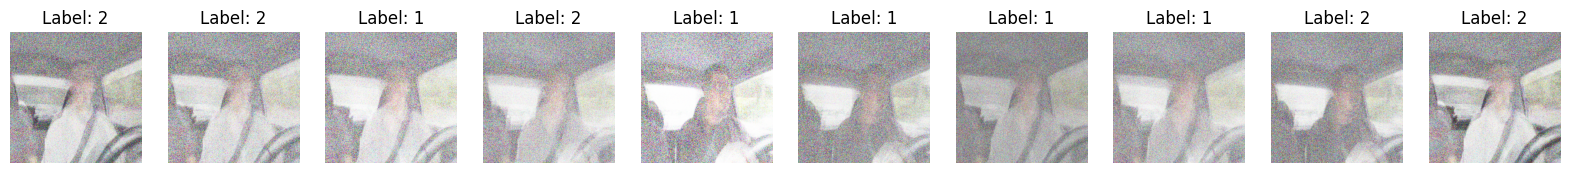

In [66]:
# Display the images and their predicted labels
display_images(generated_images, predicted_labels)

Now we can save these images to a directory

In [70]:
gan_image_folder = 'C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\GAN\\GAN_generated_images'
os.chdir(gan_image_folder)
os.getcwd()

'C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\GAN\\GAN_generated_images'

In [85]:
gan_image_dict = {'img_path':[], 'label':[]}

for i, img in enumerate(generated_images):
    label = predicted_labels[i].cpu().numpy()
    img = img.reshape((3, 224, 224)) # For torch formatting 
    # Will look weird, but once reshaped it will look like an image back to original format
    saved_img = to_pil_image(denormalize(img))
    save_path = f"{os.getcwd()}/generated_image_{i}_for_label_{label}.png"
    saved_img.save(save_path)


    # Append to dict
    gan_image_dict['img_path'].append(save_path)
    gan_image_dict['label'].append(label)

In [88]:
gan_image_df  = pd.DataFrame.from_dict(gan_image_dict)

In [92]:
gan_image_df.to_csv(gan_image_folder+ "\\gan_image_df.csv", index = False)